## Description of the task and dataset

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#input data initialization
train_data_path = '../cases/data/scoring/scoring_train.csv'
test_data_path = '../cases/data/scoring/scoring_test.csv'
df = pd.read_csv(train_data_path)

In [2]:
df.head(10)

,ID,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30.59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60.89DaysPastDueNotWorse,NumberOfDependents,target
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0
5,5,0.213179,74,0,0.375607,3500.0,3,0,1,0,1.0,0
6,6,0.305682,57,0,5710.000000,NaN,8,0,3,0,0.0,0
7,7,0.754464,39,0,0.209940,3500.0,8,0,0,0,0.0,0
8,8,0.116951,27,0,46.000000,NaN,2,0,0,0,NaN,0
9,9,0.189169,57,0,0.606291,23684.0,9,0,4,0,2.0,0


## What to automate in the design of the machine learning pipeline

### Data preprocessing

In [3]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

#gap filling, target column separation
features_train = df.loc[:, df.columns != 'target']
features_train.fillna(features_train.mean(), inplace=True)
features_train = np.asarray(features_train)[:, 1:]

target_train=np.asarray(df['target'])

### Model selection and training

In [4]:
#candidate model based at DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=3)
model.fit(features_train, target_train)

DecisionTreeClassifier(max_depth=3)

In [5]:
from sklearn.model_selection import cross_val_score

#cross-validation of the model
cvs = cross_val_score(model, features_train, target_train, cv=10, scoring='roc_auc')

#quality metric
round(np.mean(cvs), 3)

0.788

### Model validation

In [6]:
#read and prepare test data
df_test = pd.read_csv(test_data_path)

features_test = df_test.loc[:, df_test.columns != 'target']
features_test.fillna(features_test.mean(), inplace=True)
features_test = np.asarray(features_test)[:, 1:]

target_test=np.asarray(df_test['target'])

In [7]:
#prediction used model fitted in previous stage

prediction = model.predict(features_test)
prediction_probs = model.predict_proba(features_test)

In [8]:
print(prediction)
print(prediction_probs)

[0 0 0 ... 0 0 0]
[[0.97719506 0.02280494]
 [0.97719506 0.02280494]
 [0.60869565 0.39130435]
 ...
 [0.89308386 0.10691614]
 [0.89308386 0.10691614]
 [0.89308386 0.10691614]]


In [9]:
#caclulate ROC AUC metrics

from sklearn.metrics import roc_auc_score
roc_auc_score(target_test, prediction_probs[:, 1])

0.7729714030384273

### Model selection, hyperparameter tuning

In [10]:
# test model setup 1

model_new = DecisionTreeClassifier(max_depth=4)
model_new.fit(features_train, target_train)

prediction_probs_new = model_new.predict_proba(features_test)

roc_auc_score(target_test, prediction_probs_new[:, 1])

0.8016453182404926

In [11]:
# test model setup 2

model_new = DecisionTreeClassifier(max_depth=7)
model_new.fit(features_train, target_train)

prediction_probs_new = model_new.predict_proba(features_test)

roc_auc_score(target_test, prediction_probs_new[:, 1])

0.7932538973289643

In [12]:
# test model setup 3

from sklearn.ensemble import GradientBoostingClassifier

model_new = GradientBoostingClassifier(n_estimators=30)
model_new.fit(features_train, target_train)

prediction_probs_new = model_new.predict_proba(features_test)

best_manual_score = round(roc_auc_score(target_test, prediction_probs_new[:, 1]), 3)
print(best_manual_score)

0.844


## Semi-automated feature selection

In [13]:
#use feature selection tool

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

sel = SelectKBest(chi2, k=8)
selected_features = sel.fit_transform(features_train, target_train)
selected_features_test = sel.transform(features_test)

In [14]:
print(features_train.shape)
print(selected_features.shape)

(20000, 10)
(20000, 8)


In [15]:
# perform search of the most appropriate features set

from sklearn.ensemble import GradientBoostingClassifier

feat_nums = range(10, 1, -1)
qualities = []
for feat_num in feat_nums:
    sel = SelectKBest(chi2, k=feat_num)
    selected_features = sel.fit_transform(features_train, target_train)
    selected_features_test = sel.transform(features_test)

    model_new = GradientBoostingClassifier(n_estimators=30)
    model_new.fit(selected_features, target_train)

    prediction_probs_new = model_new.predict_proba(selected_features_test)

    qualities.append(roc_auc_score(target_test, prediction_probs_new[:, 1]))
    
print(round(max(qualities), 3))

0.845


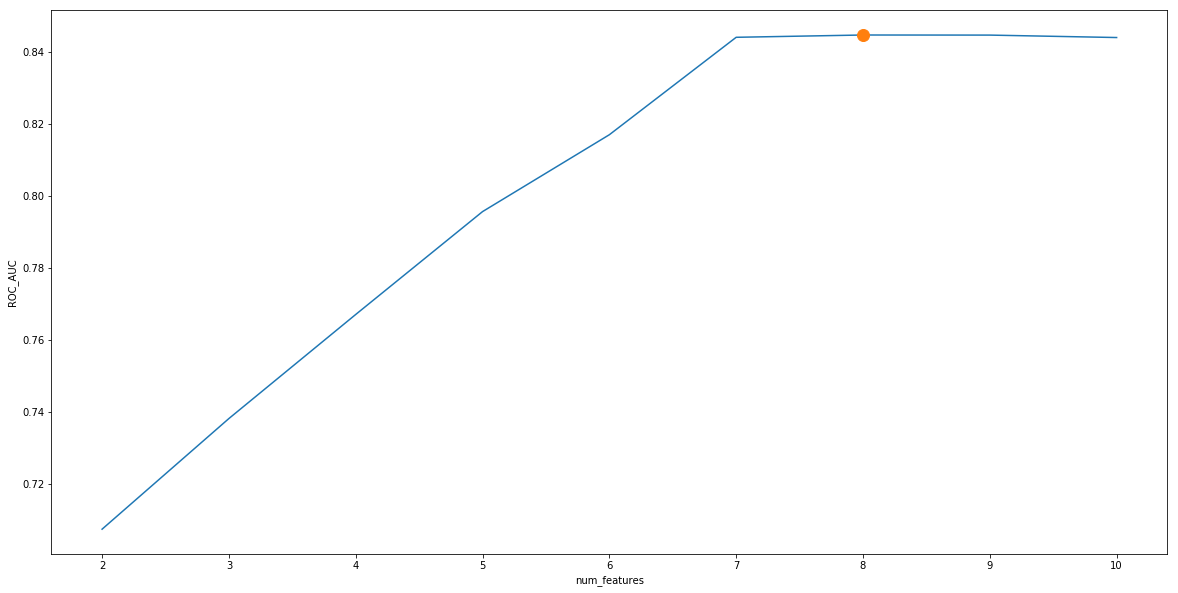

In [29]:
#plot the results of feature selection

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(feat_nums, qualities)
plt.plot(feat_nums[qualities.index(max(qualities))], max(qualities), marker='o', markersize=12)
plt.xlabel('num_features')
plt.ylabel('ROC_AUC')

best_manual_solution_roc_auc = max(qualities)

## AutoML for pipeline design (FEDOT framework example)

In [ ]:
#install specific version of the AutoML framework FEDOT

pip install git+https://github.com/nccr-itmo/FEDOT.git@jupyter-intro

In [19]:
from fedot.api.api_runner import Fedot

#task selection, initialisation of the framework
scoring_model = Fedot(ml_task='classification')

In [20]:
#run of the AutoML-based model generation
scoring_model.fit(features=train_data_path, target='target')

Best metric is -0.8091076666666667
Generation num: 0
max_depth: 3, no improvements: 0
spent time: 1.6 min
Best metric is -0.8150936666666666
Composition time: 1.55 min
Algorithm was terminated due to processing time limit
GP composition finished
Fit chain from scratch


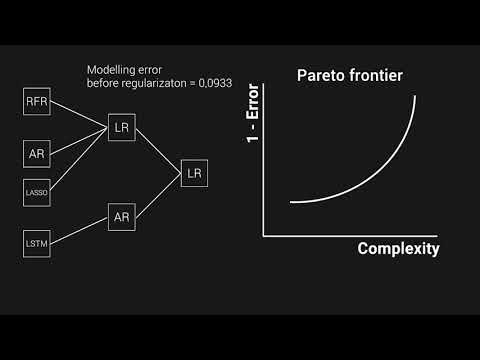

In [46]:
#Internal logic of the evolutionary AutoML
#https://www.youtube.com/watch?v=RjbuV6i6de4&ab_channel=NSS-Lab

from IPython.lib.display import YouTubeVideo
YouTubeVideo('RjbuV6i6de4', width=800, height = 600)

In [24]:
prediction = scoring_model.predict(features=test_data_path)
auto_roc_auc = scoring_model.quality_metric()
print(-auto_roc_auc)

0.855


In [45]:
#comparison with the manual pipeline

#quality

print('Quality comparison')
print('Manual solution', round(best_manual_solution_roc_auc, 3))
print('AutoML solution', -auto_roc_auc)

#time (example)
print('\nTime comparison')
print('Manual solution','2 days of expert work, 1 hour of computations')
print('AutoML solution','2 hour of expert work, 4 hours of computations')

#code lines
print('\nCode length comparison')
print('AutoML solution','5 lines of code')
print('Manual solution','100+ lines of code')


Quality comparison
Manual solution 0.845
AutoML solution 0.855

Time comparison
Manual solution 2 days of expert work, 1 hour of computations
AutoML solution 2 hour of expert work, 4 hours of computations

Code length comparison
AutoML solution 5 lines of code
Manual solution 100+ lines of code


## AutoML for the time series forecasting

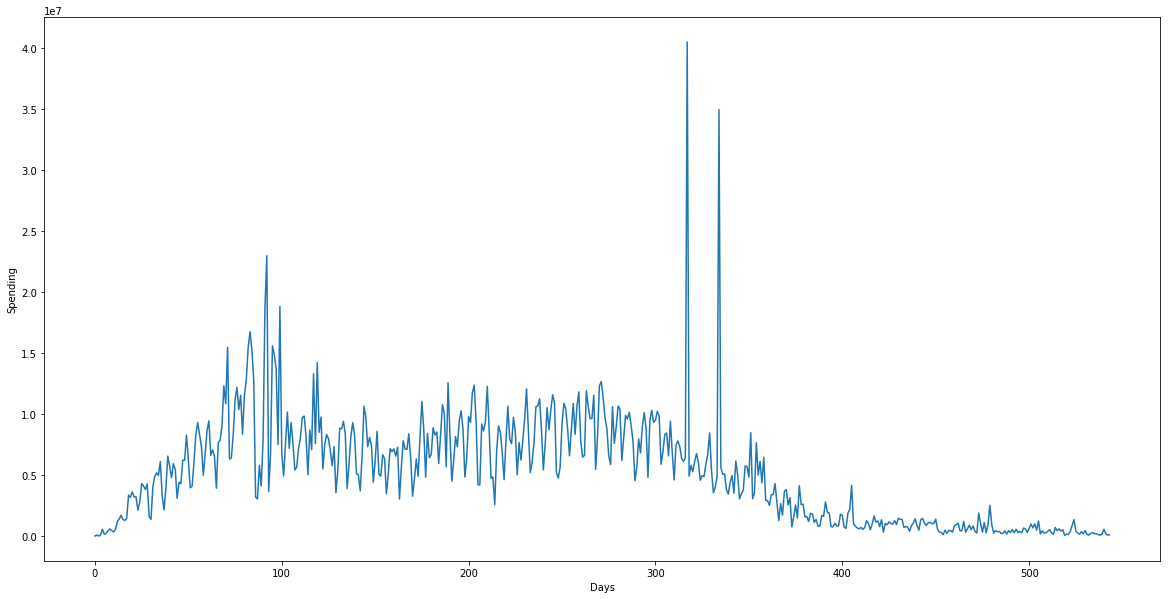

In [36]:
#read and plot the time series data

import matplotlib.pyplot as plt
import pandas as pd

train_data_path = './jupyter_media/intro/salaries.csv'
train_data = pd.read_csv(train_data_path)

plt.figure(figsize=(20,10))
plt.plot(train_data['target'])
plt.xlabel('Days')
plt.ylabel('Spending')
plt.show()

In [37]:
# init model for the time series forecasting

from fedot.api.api_runner import Fedot
from fedot.core.repository.tasks import TsForecastingParams

composer_params = {'max_depth': 1,
                   'max_arity': 2,
                   'learning_time': 3,
                   'with_tuning': False}

model = Fedot(ml_task='ts_forecasting', composer_params=composer_params,
                  task_params=TsForecastingParams(forecast_length=30,
                                                  max_window_size=30,
                                                  make_future_prediction=True))

### The logic of the preprocessing for the time series data:

![fig_2_autoregressive_models.png](https://raw.githubusercontent.com/nccr-itmo/FEDOT/master/notebooks/jupyter_media/time_series_forecasting/fig_2_autoregressive_models.png)  

In [42]:
#run AutoML model design

chain = model.fit(features=train_data_path, target='target')

Best metric is 5165419.095969686
Generation num: 0
max_depth: 1, no improvements: 0
spent time: 1.2 min
Best metric is 4859067.006400824
Generation num: 1
max_depth: 1, no improvements: 0
spent time: 2.2 min
Best metric is 4859067.006400824
Composition time: 2.233 min
Algorithm was terminated due to processing time limit
GP composition finished
Fit chain from scratch


### Example of the model quality convergence (for the long run)

![conv.png](https://i.ibb.co/6vDjwHh/conv.png)  

In [43]:
# use model to obtain forecast

ts_forecast = model.forecast(pre_history=train_data_path, forecast_length = 30)

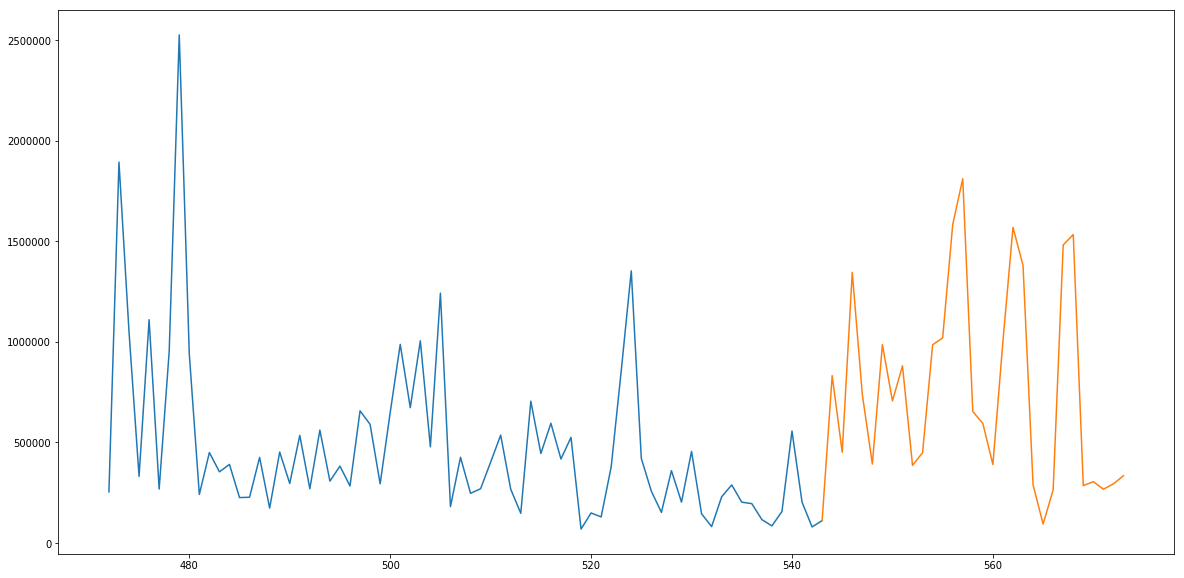

In [44]:
#plot forecasting result

import matplotlib.pyplot as plt
last_ind = int(round(model.train_data.idx[-1]))
plt.figure(figsize=(20,10))
plt.plot(model.train_data.idx[-72:], model.train_data.target[-72:])
plt.plot(range(last_ind,last_ind+len(ts_forecast)+1), np.append(model.train_data.target[-1], ts_forecast))